In [1]:
import pandas as pd
import ray
from multiprocessing import Process, Pipe
import xgboost as xgb
import numpy as np 
import keras
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
import tensorflow
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
import matplotlib.gridspec as gridspec

Using TensorFlow backend.


# Make Dataset

input parameters

Да знаю я, что из z-score p-value более, чем спокойно считается (если знать респредение особенно спокойно) и можно выбрать что-то одно. но проще так

In [2]:
cell_type = 'K562'
experiment = 'GSM4041593_K562_rep1.hg38'
k = 4

In [3]:
k_mer_path = '/Users/pitikov_egor/Documents/CourseWork/genomes/reds_experiments/%s/parsed_contacts_%s/rna_kmers_number/%s_mers' % (cell_type, experiment, k)
cont_data_path = '/Users/pitikov_egor/Documents/CourseWork/genomes/reds_experiments/%s/parsed_contacts_%s' % (cell_type, experiment)

In [4]:
params = {'pval_trash_good': 0.05,
          'pval_trash_bad': 0.95,
          'rna_count_trash':  900,
          'cont_count_trash': 0,
          'zscore_trash_good': 3,
          'zscore_trash_bad_max': 1,
          'zscore_trash_bad_min': -1,
          'class_trash_good': [''],
          'class_trash_bad': ['protein_coding']}
#I don't use classes

In [5]:
def make_sets_good(k_mer_table, contact_data_table, params):
    k_mers = pd.read_table(k_mer_table, sep='\t', header=None)
    contacts = pd.read_table(contact_data_table, sep='\t')
    contacts = contacts[contacts['pval']!='False']
    contacts = contacts.astype({"pval": float, 'contacts_count': int, 'rnaseq_count': int, 'zscore': float})
    good_contacts = contacts[
        (contacts['pval'] <= params['pval_trash_good']) &
        (contacts['rnaseq_count'] >= params['rna_count_trash']) &
        (contacts['zscore'] >= params['zscore_trash_good']) &
        (contacts['contacts_count'] >= params['cont_count_trash']) #&
        #(contacts['gene_type'] in params['class_trash_good'])
     ]
    out_table_good = pd.merge(left=good_contacts, right=k_mers, left_on='id', right_on=0, how ='inner')
    out_table_good['class'] = 1
    for i in good_contacts.columns:
        out_table_good.pop(i)
    out_table_good.pop(1)
    return out_table_good
    
    

In [6]:
def make_sets_bad(k_mer_table, contact_data_table, params):
    k_mers = pd.read_table(k_mer_table, sep='\t', header=None)
    contacts = pd.read_table(contact_data_table, sep='\t')
    contacts = contacts[contacts['pval']!='False']
    contacts = contacts.astype({"pval": float, 'contacts_count': int, 'rnaseq_count': int, 'zscore': float})
    bad_contacts = contacts[
        (contacts['pval'] >= params['pval_trash_bad']) &
        (contacts['rnaseq_count'] >= params['rna_count_trash']) &
        (contacts['zscore'] <= params['zscore_trash_bad_max']) &
        (contacts['zscore'] >= params['zscore_trash_bad_min']) &
        (contacts['contacts_count'] >= params['cont_count_trash']) #&
       # (contacts['gene_type'] in params['class_trash_bad'])
     ]
    out_table_bad = pd.merge(left=bad_contacts, right=k_mers, left_on='id', right_on=0, how ='inner')
    out_table_bad ['class'] = 0
    for i in bad_contacts.columns:
        out_table_bad.pop(i)
    out_table_bad.pop(1)
    return out_table_bad
    
    

In [7]:
chr_names=['chrX', 'chrY']
for i in range(1, 23):
    chr_names.append('chr%d' % (i))

In [8]:

all_cont_kmers = pd.concat([
    make_sets_good('%s/%s.tsv' % (k_mer_path, chr_names[0]), '%s/%s_full_%s.pvalue.tab.txt' % (cont_data_path, chr_names[0], cell_type), params),
    make_sets_bad('%s/%s.tsv' % (k_mer_path, chr_names[0]), '%s/%s_full_%s.pvalue.tab.txt' % (cont_data_path, chr_names[0], cell_type), params)], 
    sort=False)
for i in chr_names[1:]:
    all_cont_kmers = pd.concat([
        all_cont_kmers,
        make_sets_good('%s/%s.tsv' % (k_mer_path, i), '%s/%s_full_%s.pvalue.tab.txt' % (cont_data_path, i, cell_type), params),
        make_sets_bad('%s/%s.tsv' % (k_mer_path, i), '%s/%s_full_%s.pvalue.tab.txt' % (cont_data_path, i, cell_type), params)],
        sort=False)

/Users/pitikov_egor/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [9]:
all_cont_kmers.reset_index(drop=True, inplace=True)

In [10]:
all_cont_kmers

,0,2,3,4,5,6,7,8,9,10,...,249,250,251,252,253,254,255,256,257,class
0,M01460:89:000000000-AJJ2J:1:1101:10341:2716,1,1,0,0,2,2,0,0,0,...,2,0,1,0,0,1,2,0,5,0
1,M01460:89:000000000-AJJ2J:1:1101:11646:12424,0,0,0,2,1,1,0,0,0,...,5,0,1,2,1,5,3,1,6,0
2,M01460:89:000000000-AJJ2J:1:1101:12165:2828,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M01460:89:000000000-AJJ2J:1:1101:12400:4818,4,0,0,3,0,1,0,0,1,...,2,0,0,0,2,0,1,1,0,0
4,M01460:89:000000000-AJJ2J:1:1101:12491:13938,0,0,0,1,0,0,1,0,0,...,2,5,1,1,2,3,0,4,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41493,M01460:89:000000000-AJJ2J:1:2119:19384:9668,0,0,0,3,0,0,0,1,0,...,2,0,1,3,7,0,2,0,0,0
41494,M01460:89:000000000-AJJ2J:1:2119:21209:7134,122,34,30,67,32,29,2,36,41,...,63,50,39,41,57,71,53,70,179,0
41495,M01460:89:000000000-AJJ2J:1:2119:22399:18443,3,0,2,2,0,0,0,0,5,...,1,1,1,0,3,0,3,2,0,0
41496,M01460:89:000000000-AJJ2J:1:2119:25177:13799,0,0,1,1,0,0,0,0,2,...,0,2,1,1,1,2,0,1,0,0


In [11]:
all_cont_kmers[all_cont_kmers['class']==1].count()[0]

822

In [12]:
all_cont_kmers_set = pd.concat([
        all_cont_kmers[all_cont_kmers['class']==1],
        all_cont_kmers[all_cont_kmers['class']==0].sample(5*all_cont_kmers[all_cont_kmers['class']==1].count()[0])],
        sort=False)

In [13]:
all_cont_kmers_set

,0,2,3,4,5,6,7,8,9,10,...,249,250,251,252,253,254,255,256,257,class
26512,M01460:89:000000000-AJJ2J:1:1101:10630:2092,0,0,0,2,1,1,1,0,1,...,1,0,2,1,1,2,1,1,2,1
26513,M01460:89:000000000-AJJ2J:1:1101:13592:7247,0,0,0,2,1,1,1,0,1,...,1,0,2,1,1,2,1,1,2,1
26514,M01460:89:000000000-AJJ2J:1:1101:14639:3053,0,0,1,2,1,1,1,0,2,...,2,0,2,2,1,2,1,2,3,1
26515,M01460:89:000000000-AJJ2J:1:1101:15039:5284,0,0,0,2,1,1,1,0,1,...,0,0,2,1,1,2,1,1,2,1
26516,M01460:89:000000000-AJJ2J:1:1101:15321:4960,0,0,0,2,1,1,1,0,1,...,1,0,2,1,1,2,1,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38741,M01460:89:000000000-AJJ2J:1:1102:12083:18251,0,1,0,2,0,1,1,0,0,...,0,1,1,0,1,0,1,1,1,0
4047,M01460:89:000000000-AJJ2J:1:1118:15095:22098,1,0,1,1,0,1,0,0,1,...,0,2,0,1,2,3,0,3,6,0
30840,M01460:89:000000000-AJJ2J:1:1102:24290:3225,0,1,1,0,0,1,0,1,1,...,0,2,1,1,1,1,0,1,2,0
23669,M01460:89:000000000-AJJ2J:1:2102:17197:15715,4,0,1,2,1,0,0,0,4,...,1,0,1,2,1,1,1,2,3,0


In [14]:
cont_arr = all_cont_kmers_set.to_numpy()

In [15]:
cont_arr

array([['M01460:89:000000000-AJJ2J:1:1101:10630:2092', 0, 0, ..., 1, 2,
        1],
       ['M01460:89:000000000-AJJ2J:1:1101:13592:7247', 0, 0, ..., 1, 2,
        1],
       ['M01460:89:000000000-AJJ2J:1:1101:14639:3053', 0, 0, ..., 2, 3,
        1],
       ...,
       ['M01460:89:000000000-AJJ2J:1:1102:24290:3225', 0, 1, ..., 1, 2,
        0],
       ['M01460:89:000000000-AJJ2J:1:2102:17197:15715', 4, 0, ..., 2, 3,
        0],
       ['M01460:89:000000000-AJJ2J:1:1109:15717:8033', 1, 2, ..., 5, 2,
        0]], dtype=object)

In [16]:
#cont_data = np.resize(cont_arr[:, 1:-1], tuple([len(cont_arr)] + [4]*k))
cont_data = cont_arr[:, 1:-1]

In [17]:
cont_data

array([[0, 0, 0, ..., 1, 1, 2],
       [0, 0, 0, ..., 1, 1, 2],
       [0, 0, 1, ..., 1, 2, 3],
       ...,
       [0, 1, 1, ..., 0, 1, 2],
       [4, 0, 1, ..., 1, 2, 3],
       [1, 2, 2, ..., 0, 5, 2]], dtype=object)

In [18]:
cont_class = cont_arr[:, -1]

In [19]:
cont_class

array([1, 1, 1, ..., 0, 0, 0], dtype=object)

In [20]:
data_train, data_test, label_train, label_test = train_test_split(cont_data, cont_class, test_size=0.2, random_state=42)

## Linear Model

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
clf = LogisticRegression().fit(data_train, list(label_train))

clf.predict(data_test)

precision_score(list(label_test), clf.predict(data_test))


/Users/pitikov_egor/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1.0

In [23]:
fpr, tpr, thresholds = roc_curve(list(label_test), clf.predict(data_test))

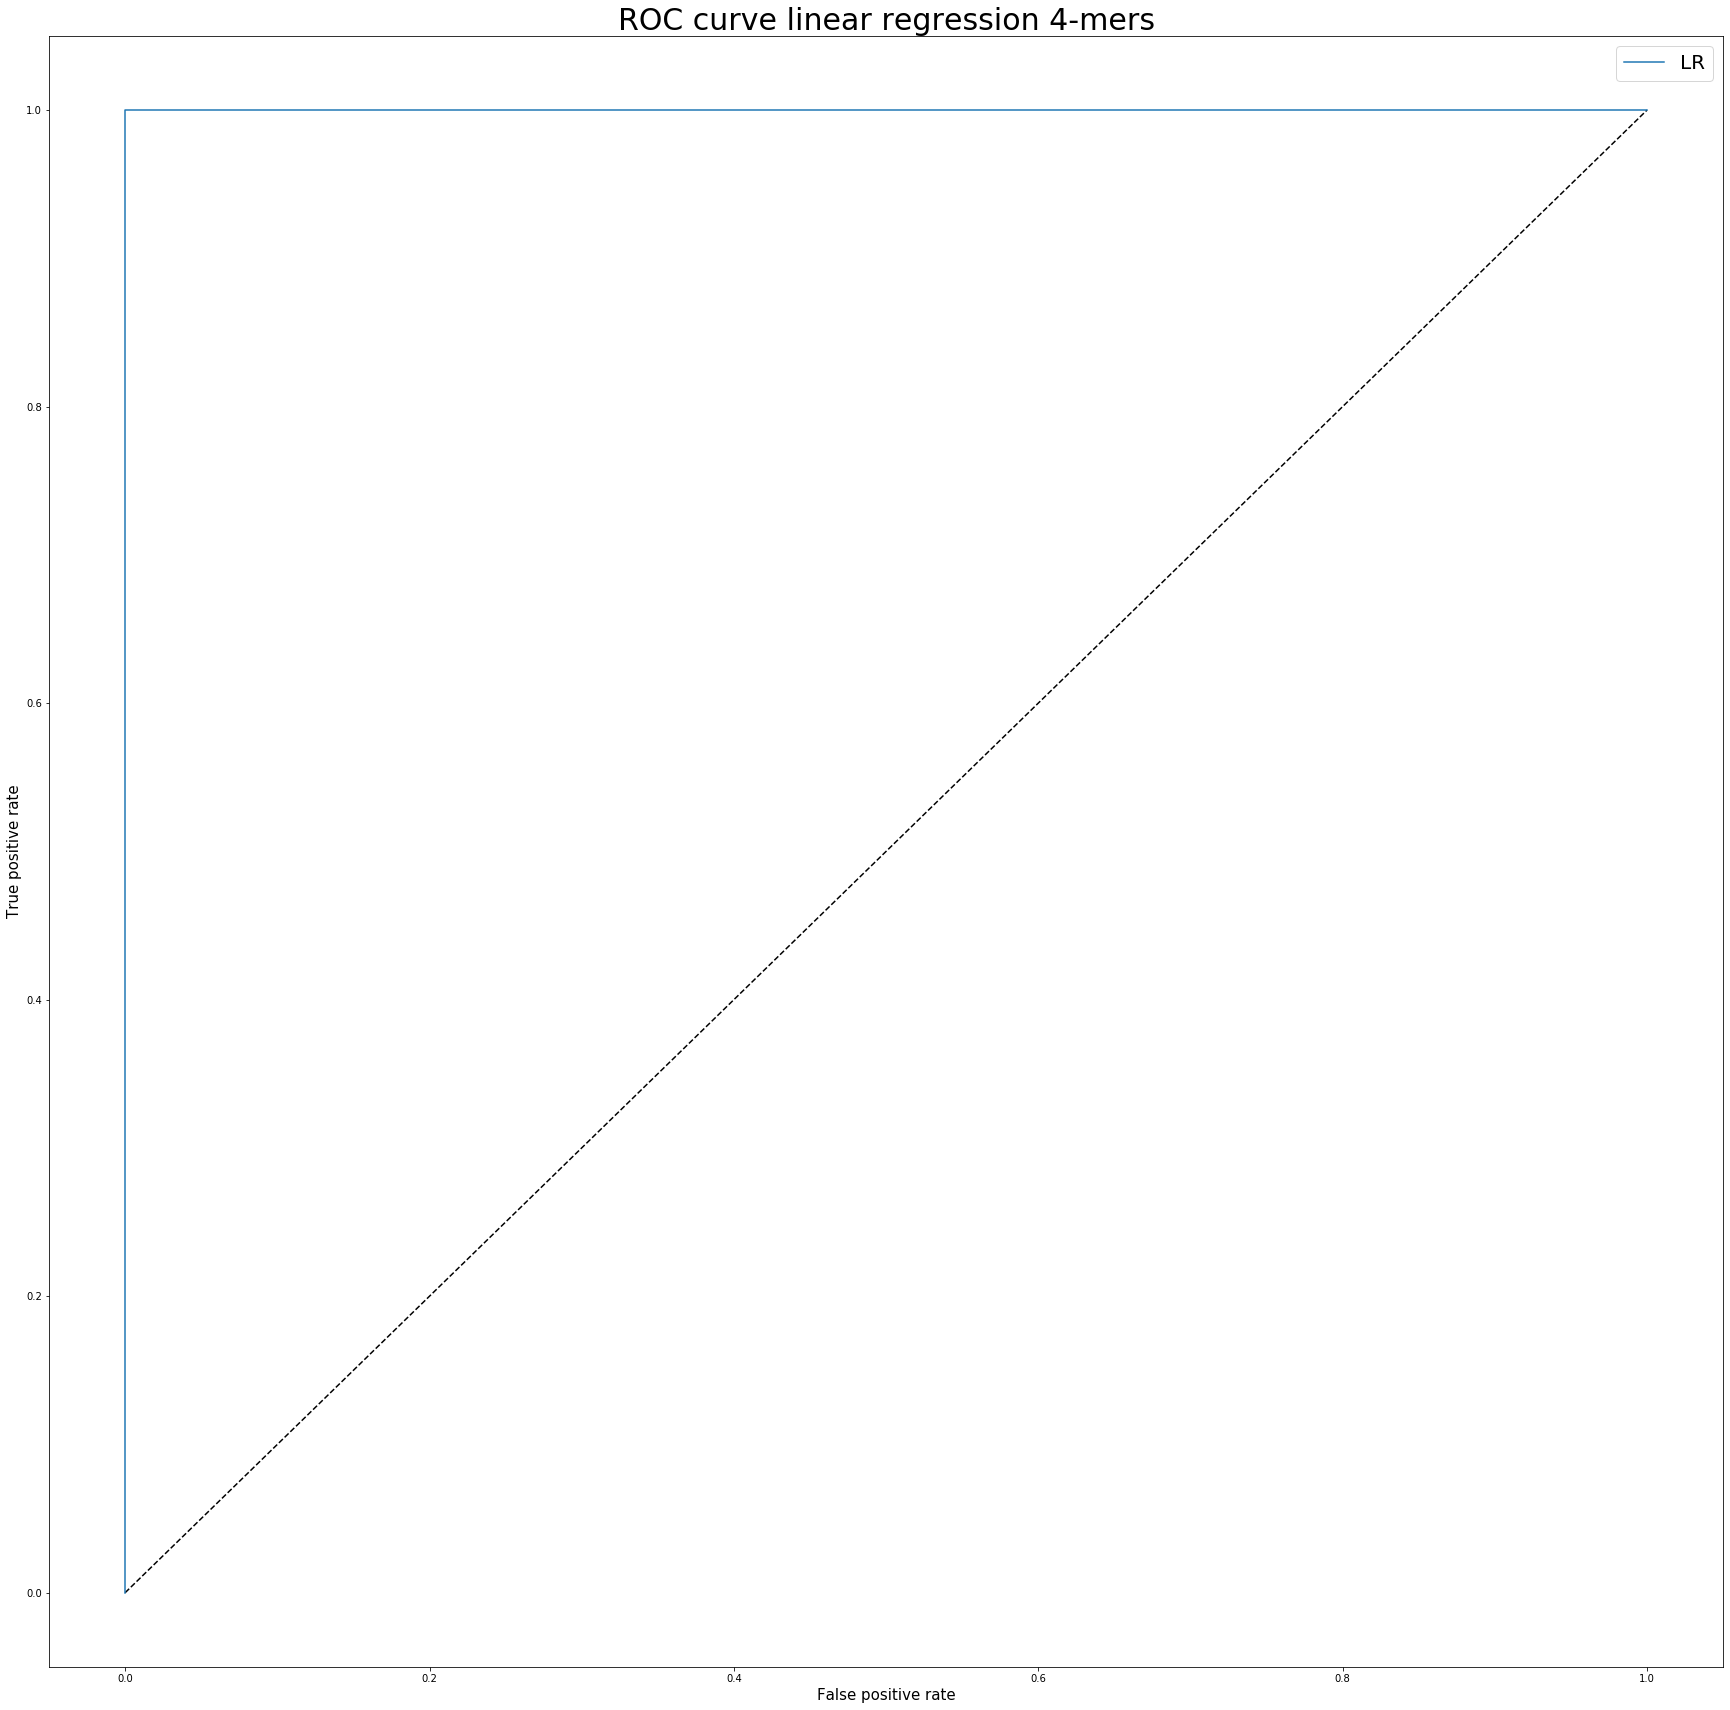

In [24]:
plt.figure(1, figsize=(30, 30))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate', fontsize=15)
plt.title('ROC curve linear regression 4-mers', fontsize=30)
plt.legend(loc='best', fontsize=20)
plt.show()

## XGBoost

In [25]:
dtrain = xgb.DMatrix(data_train, label=label_train)
dtest = xgb.DMatrix(data_test, label=label_test)

In [30]:
param = {
    'max_depth': 1000,
    'eta': 0.2, 
    'max_delta_step': 2.0,
    'objective': 'multi:softprob',
    'num_class': 2,
    'nthread' : 10,
    'num_parallel_tree': 2,
    }
num_boost_round = 50

In [31]:
bst = xgb.train(param, dtrain, num_boost_round=num_boost_round)

trees = [s for s in bst]
assert len(trees) == num_boost_round

[16:06:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [32]:
preds = bst.predict(dtest)

In [33]:
preds

array([[9.9984026e-01, 1.5971489e-04],
       [9.9983680e-01, 1.6321833e-04],
       [9.9990058e-01, 9.9418401e-05],
       ...,
       [9.9986255e-01, 1.3741673e-04],
       [9.9990022e-01, 9.9822799e-05],
       [9.9991405e-01, 8.5885658e-05]], dtype=float32)

In [34]:
best_preds = np.asarray([np.argmax(line) for line in preds])

In [35]:
precision_score(list(label_test), best_preds)

1.0

In [36]:
fpr, tpr, thresholds = roc_curve(list(label_test), list(preds[:, 1]))

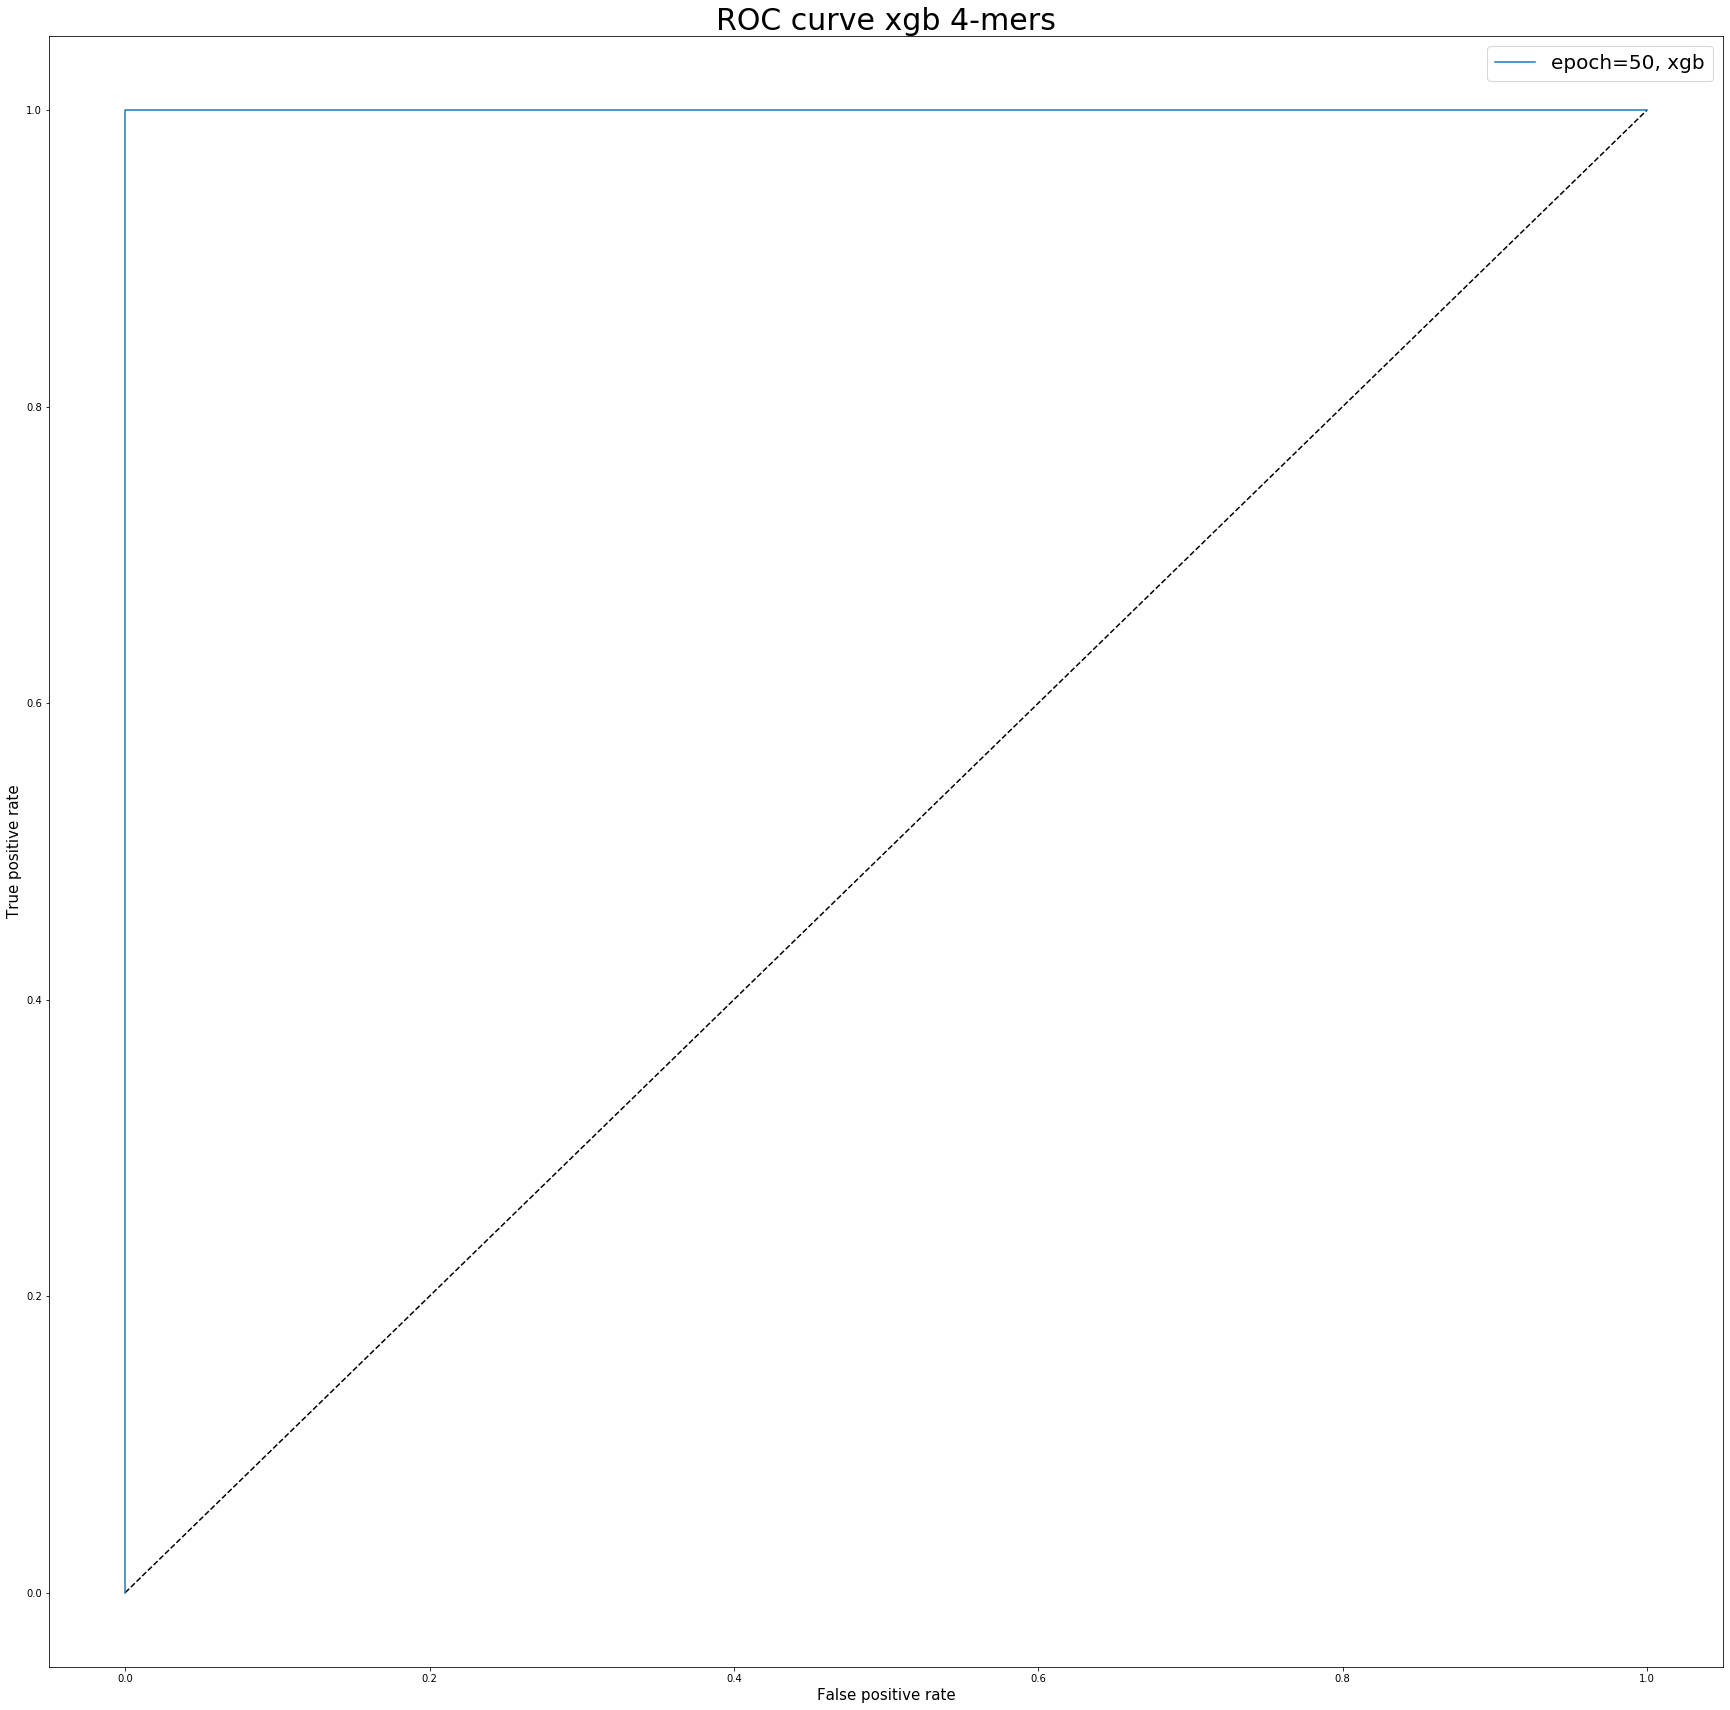

In [37]:
plt.figure(1, figsize=(30, 30))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='epoch=50, xgb')
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate', fontsize=15)
plt.title('ROC curve xgb 4-mers', fontsize=30)
plt.legend(loc='best', fontsize=20)
plt.show()

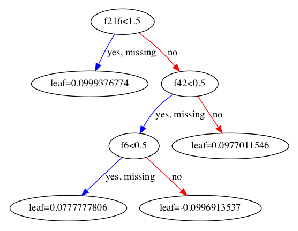

In [38]:
xgb.plot_tree(bst)

In [39]:
name = 'xgb_version_23'
bst.save_model('/Users/pitikov_egor/Documents/CourseWork/genomes/%s.json' % name)

## XGBoost predict on all dataset (it's nogood)

In [40]:
all_all_kmers = pd.read_table('%s/%s.tsv' % (k_mer_path, chr_names[0]), sep='\t', header=None)
print(len(all_all_kmers[0]))
for i in chr_names[1:]:
    all_all_kmers = pd.concat([
        all_all_kmers,
        pd.read_table('%s/%s.tsv' % (k_mer_path, i), sep='\t', header=None)],
        sort=False)
    print(len(all_all_kmers[0]))

33272
33279
184412
324565
413082
477116
556547
649948
763331
834145
892991
951898
1063136
1126547
1176689
1233759
1267261
1307410
1354724
1392002
1431118
1453909
1480184
1512677


In [41]:
all_all_kmers.reset_index(drop = True, inplace=True)

In [42]:
all_all_kmers = all_all_kmers.to_numpy()

In [43]:
all_all_kmers [:, 2:]

array([[1, 1, 1, ..., 0, 1, 0],
       [1, 0, 1, ..., 3, 1, 20],
       [1, 0, 3, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 4, 2],
       [2, 1, 0, ..., 1, 1, 0],
       [0, 0, 2, ..., 0, 0, 0]], dtype=object)

In [44]:
full_kmers = xgb.DMatrix(all_all_kmers[:, 2:])

In [45]:
preds = bst.predict(full_kmers)

In [46]:
preds

array([[9.99897957e-01, 1.02012673e-04],
       [9.99900222e-01, 9.98227988e-05],
       [9.99884486e-01, 1.15551404e-04],
       ...,
       [9.99861836e-01, 1.38157746e-04],
       [9.99864340e-01, 1.35665337e-04],
       [9.99860168e-01, 1.39765281e-04]], dtype=float32)

In [47]:
best_preds = np.asarray([np.argmax(line) for line in preds])

In [48]:
best_preds

array([0, 0, 0, ..., 0, 0, 0])

In [49]:
np.count_nonzero(best_preds == 1)

976

In [50]:
len(best_preds)

1512677

In [51]:
def make_sets_all(k_mer_table, contact_data_table):
    k_mers = pd.read_table(k_mer_table, sep='\t', header=None)
    contacts = pd.read_table(contact_data_table, sep='\t')
    contacts = contacts[contacts['pval']!='False']
    contacts = contacts.astype({"pval": float, 'contacts_count': int, 'rnaseq_count': int, 'zscore': float})
    out_table = pd.merge(left=contacts, right=k_mers, left_on='id', right_on=0, how ='inner')
    return out_table
    

In [52]:
all_all_kmers = make_sets_all('%s/%s.tsv' % (k_mer_path, chr_names[0]), '%s/%s_full_%s.pvalue.tab.txt' % (cont_data_path, chr_names[0], cell_type)) 
for i in chr_names[1:]:
    all_all_kmers = pd.concat([
        all_all_kmers,
        make_sets_all('%s/%s.tsv' % (k_mer_path, i), '%s/%s_full_%s.pvalue.tab.txt' % (cont_data_path, i, cell_type))],
        sort=False)

/Users/pitikov_egor/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [53]:
all_kmers = all_all_kmers.to_numpy()

In [54]:
all_kmers

array([['chrX', 'M01460:89:000000000-AJJ2J:1:1101:10052:11799',
        'ARHGAP6', ..., 1, 0, 1],
       ['chrX', 'M01460:89:000000000-AJJ2J:1:1101:10120:22859', 'POLA1',
        ..., 2, 3, 2],
       ['chrX', 'M01460:89:000000000-AJJ2J:1:1101:10165:1272', 'FTX',
        ..., 1, 2, 1],
       ...,
       ['chr22', 'M01460:89:000000000-AJJ2J:1:2119:9949:5292', 'MAPK1',
        ..., 3, 2, 1],
       ['chr22', 'M01460:89:000000000-AJJ2J:1:2119:9986:9333', 'DGCR8',
        ..., 2, 3, 6],
       ['chr22', 'M01460:89:000000000-AJJ2J:1:2119:9988:6880', 'TTC28',
        ..., 1, 5, 7]], dtype=object)

In [55]:
data_kmer = all_kmers[:, 11:]

In [56]:
full_kmers = xgb.DMatrix(all_kmers[:, 11:])

In [57]:
preds = bst.predict(full_kmers)

In [58]:
best_preds = np.asarray([np.argmax(line) for line in preds])

In [59]:
gene_types = set(all_all_kmers['gene_type'])

In [60]:
s = np.expand_dims(all_kmers[:, 3], axis=0)

In [61]:
#s = np.resize(s, tuple([2, len(best_preds)]))
s

array([['protein_coding', 'protein_coding', 'lncRNA', ...,
        'protein_coding', 'protein_coding', 'protein_coding']],
      dtype=object)

In [62]:
s = np.concatenate((np.expand_dims(best_preds, axis=0), np.expand_dims(all_kmers[:, 3], axis=0)), axis=0)

In [63]:
s = np.transpose(s)
s

array([[0, 'protein_coding'],
       [0, 'protein_coding'],
       [0, 'lncRNA'],
       ...,
       [0, 'protein_coding'],
       [0, 'protein_coding'],
       [0, 'protein_coding']], dtype=object)

In [64]:
(s[:, 0] == 0) & (s[:, 1] == 'lncRNA')

array([False, False,  True, ..., False, False, False])

In [65]:
means = {}
for i in gene_types:
    spec = np.count_nonzero((s[:, 0] == 1) & (s[:, 1] == i))
    nonspec = np.count_nonzero((s[:, 0] == 0) & (s[:, 1] == i))
    print('%s have %s specific and %s nonspecific contacts' % (i, spec, nonspec))
    means[i] = [nonspec, spec]

transcribed_unitary_pseudogene have 0 specific and 1070 nonspecific contacts
miRNA have 0 specific and 57 nonspecific contacts
unprocessed_pseudogene have 0 specific and 469 nonspecific contacts
unitary_pseudogene have 0 specific and 8 nonspecific contacts
scaRNA have 0 specific and 585 nonspecific contacts
polymorphic_pseudogene have 0 specific and 12 nonspecific contacts
ribozyme have 0 specific and 748 nonspecific contacts
processed_pseudogene have 0 specific and 580 nonspecific contacts
transcribed_unprocessed_pseudogene have 1 specific and 5324 nonspecific contacts
protein_coding have 912 specific and 1162627 nonspecific contacts
misc_RNA have 0 specific and 445 nonspecific contacts
snRNA have 822 specific and 4472 nonspecific contacts
transcribed_processed_pseudogene have 0 specific and 8676 nonspecific contacts
scRNA have 0 specific and 1 nonspecific contacts
IG_V_gene have 0 specific and 4 nonspecific contacts
snoRNA have 0 specific and 4922 nonspecific contacts
lncRNA have 1 s

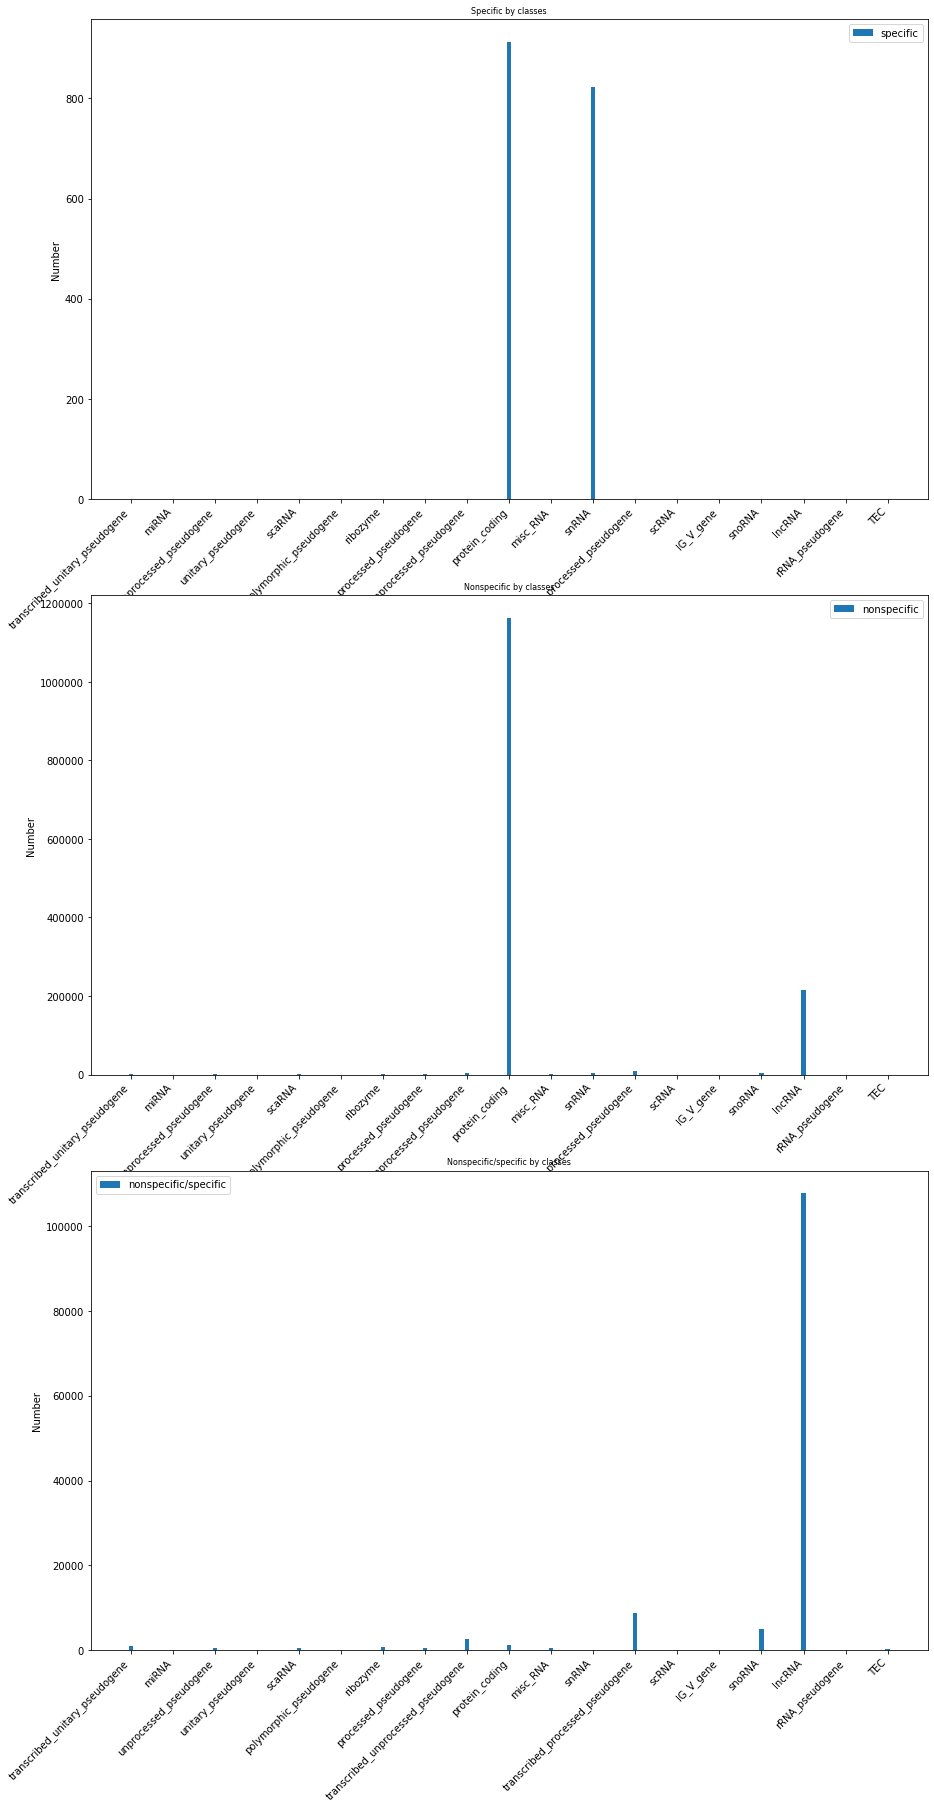

In [66]:
plt.rcParams['axes.titlesize'] = 8
fig = plt.figure(1, figsize=(15, 30))
gs = gridspec.GridSpec(3, 2)
ax0 = fig.add_subplot(gs[0, :])
spec = ax0.bar(np.arange(len(means.keys())), [means[i][1] for i in means.keys()], 0.1, label='specific')
ax0.set_ylabel('Number')
ax0.set_title('Specific by classes')
ax0.set_xticks(np.arange(len(means.keys()))) 
ax0.set_xticklabels(means.keys(), rotation=45,  ha="right", position=(0, 0))
ax0.legend()
ax1 = fig.add_subplot(gs[1, :])
nonspec = ax1.bar(np.arange(len(means.keys())), [means[i][0] for i in means.keys()], 0.1, label='nonspecific')
ax1.set_ylabel('Number')
ax1.set_title('Nonspecific by classes')
ax1.set_xticks(np.arange(len(means.keys())))
ax1.set_xticklabels(means.keys(), rotation=45,  ha="right", position=(0, 0))
ax1.legend()
ax2 = fig.add_subplot(gs[2, :])
nonspec = ax2.bar(np.arange(len(means.keys())), [means[i][0]/(means[i][1]+1) for i in means.keys()], 0.1, label='nonspecific/specific')
ax2.set_ylabel('Number')
ax2.set_title('Nonspecific/specific by classes')
ax2.set_xticks(np.arange(len(means.keys())))
ax2.set_xticklabels(means.keys(), rotation=45,  ha="right", position=(0, 0))
ax2.legend()
plt.show()


# For linear model

In [67]:
preds = clf.predict(data_kmer)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [68]:
preds

array([0, 0, 0, ..., 0, 0, 0])

In [69]:
gene_types = set(all_all_kmers['gene_type'])

In [70]:
s = np.concatenate((np.expand_dims(best_preds, axis=0), np.expand_dims(all_kmers[:, 3], axis=0)), axis=0)

In [73]:
s = np.transpose(s)

In [74]:
means = {}
for i in gene_types:
    spec = np.count_nonzero((s[:, 0] == 1) & (s[:, 1] == i))
    nonspec = np.count_nonzero((s[:, 0] == 0) & (s[:, 1] == i))
    print('%s have %s specific and %s nonspecific contacts' % (i, spec, nonspec))
    means[i] = [nonspec, spec]

transcribed_unitary_pseudogene have 0 specific and 1070 nonspecific contacts
miRNA have 0 specific and 57 nonspecific contacts
unprocessed_pseudogene have 0 specific and 469 nonspecific contacts
unitary_pseudogene have 0 specific and 8 nonspecific contacts
scaRNA have 0 specific and 585 nonspecific contacts
polymorphic_pseudogene have 0 specific and 12 nonspecific contacts
ribozyme have 0 specific and 748 nonspecific contacts
processed_pseudogene have 0 specific and 580 nonspecific contacts
transcribed_unprocessed_pseudogene have 1 specific and 5324 nonspecific contacts
protein_coding have 912 specific and 1162627 nonspecific contacts
misc_RNA have 0 specific and 445 nonspecific contacts
snRNA have 822 specific and 4472 nonspecific contacts
transcribed_processed_pseudogene have 0 specific and 8676 nonspecific contacts
scRNA have 0 specific and 1 nonspecific contacts
IG_V_gene have 0 specific and 4 nonspecific contacts
snoRNA have 0 specific and 4922 nonspecific contacts
lncRNA have 1 s

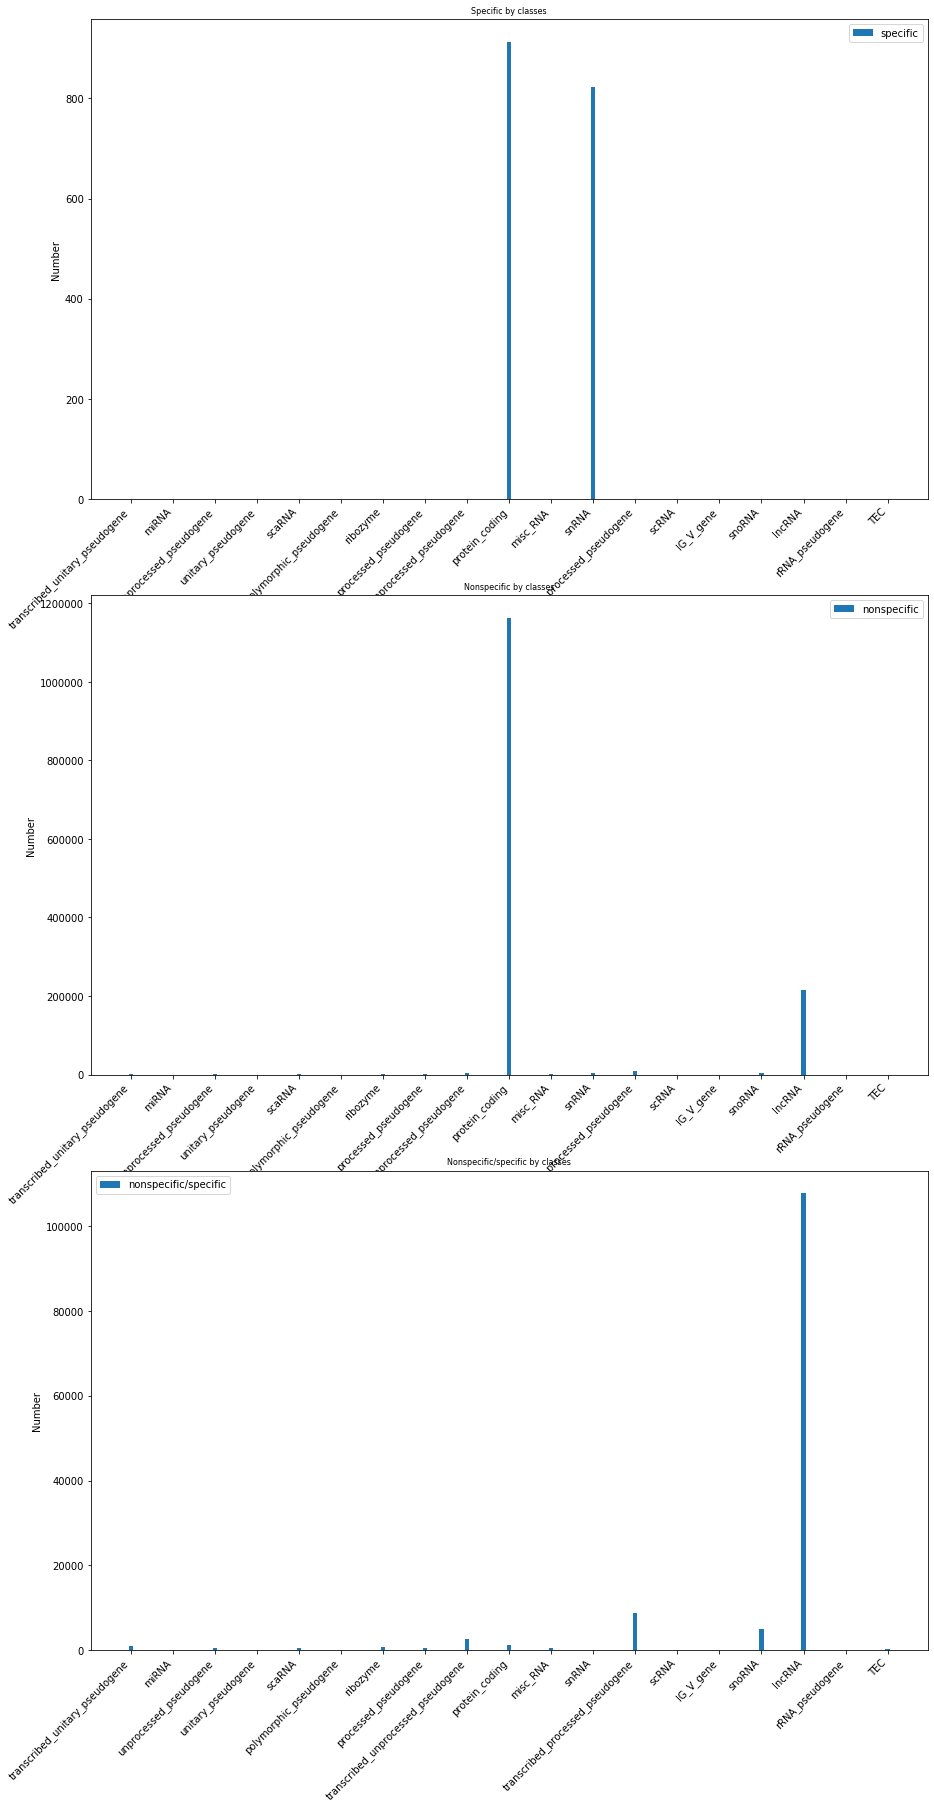

In [75]:
plt.rcParams['axes.titlesize'] = 8
fig = plt.figure(1, figsize=(15, 30))
gs = gridspec.GridSpec(3, 2)
ax0 = fig.add_subplot(gs[0, :])
spec = ax0.bar(np.arange(len(means.keys())), [means[i][1] for i in means.keys()], 0.1, label='specific')
ax0.set_ylabel('Number')
ax0.set_title('Specific by classes')
ax0.set_xticks(np.arange(len(means.keys()))) 
ax0.set_xticklabels(means.keys(), rotation=45,  ha="right", position=(0, 0))
ax0.legend()
ax1 = fig.add_subplot(gs[1, :])
nonspec = ax1.bar(np.arange(len(means.keys())), [means[i][0] for i in means.keys()], 0.1, label='nonspecific')
ax1.set_ylabel('Number')
ax1.set_title('Nonspecific by classes')
ax1.set_xticks(np.arange(len(means.keys())))
ax1.set_xticklabels(means.keys(), rotation=45,  ha="right", position=(0, 0))
ax1.legend()
ax2 = fig.add_subplot(gs[2, :])
nonspec = ax2.bar(np.arange(len(means.keys())), [means[i][0]/(means[i][1]+1) for i in means.keys()], 0.1, label='nonspecific/specific')
ax2.set_ylabel('Number')
ax2.set_title('Nonspecific/specific by classes')
ax2.set_xticks(np.arange(len(means.keys())))
ax2.set_xticklabels(means.keys(), rotation=45,  ha="right", position=(0, 0))
ax2.legend()
plt.show()



In [ ]:
genes_con = preds_to_type[[0, 1, 'id', 'gene', 'gene_ac']]
genes_con = genes_con.value_counts()
genes_con['count'] = genes_con.index
genes_con = genes_con.reset_index()